In [1]:
import os
import matplotlib.pyplot as plt
import pims
import sys
import numpy as np
sys.path.insert(0,'/home/jmamede/scripts')
# from support_pla import othercolor, cell_mask, multiply, rebin
from support_pla import cellpose_mask,cellpose_model
import pandas as pd
from nd2reader import ND2Reader
import glob
import csv
plot = True

In [18]:
# ficheiro = "/run/media/jmamede/Joao/96wells/20201119_143803_601/WellA01_ChannelGFP,DAPI_Seq0000.nd2"
dirname = '/home/jmamede/Data/tests/Well*.nd2'
filelist = glob.glob(dirname)
filelist.sort()


# reader = ND2Reader(ficheiro)
# print(reader.sizes)

# metadata = reader.metadata
# reader.bundle_axes = 'cyx'
# reader.iter_axes = 'z'
# #there is a bug, it reads each visit point as a Z.
# reader.default_coords['v'] = 0
# #reader.sizes['z']

def plots(reader,cells_masks,nuclei_masks,base):
    %matplotlib inline
    from cellpose.utils import masks_to_outlines
    f, axarr = plt.subplots(3)
    print(axarr.shape)
    axarr[0].imshow(reader[i][1],vmin=np.min(reader[5][1]),vmax=np.max(reader[5][1])/2
#         ,cmap="gray"
                     )
    axarr[0].imshow(masks_to_outlines(cells_masks),alpha=0.6,cmap='gray'
        )
#     axarr[0,2].imshow(reader[i][0],vmin=100,vmax=np.max(reader[5][0])/3
#         )
    axarr[2].imshow(reader[i][1],vmin=np.min(reader[5][1]),vmax=np.max(reader[5][1])/2
#         ,cmap="gray"
                     )
    axarr[2].imshow(cells_masks,alpha=0.4,cmap='jet')
    
    axarr[1].imshow(reader[i][0],vmin=np.min(reader[5][0]),vmax=np.max(reader[5][0])/2
#                       ,cmap="gray"
        )
    axarr[1].imshow(masks_to_outlines(nuclei_masks),alpha=0.4,cmap='gray')
        
        
#     axarr[1,2].imshow(reader[i][1],vmin=100,vmax=np.max(reader[5][0])/3
#         )
#     axarr[1,2].imshow(nuclei_masks
# #                 ,alpha=0.6
#         )
    plt.savefig(base+'v'+str(i),dpi=600)
    return f,axarr




>>>> using CPU
cellpose_residual_on_style_on_concatenation_off
>>>> using CPU
cellpose_residual_on_style_on_concatenation_off
/home/jmamede/Data/tests/WellA01_Channela647,GFP,mRuby_Seq0000.nd2 Image#: 0 Number of Nuclei: 164 Number of positive cells: 27 Percentage: 0.16463414634146342
/home/jmamede/Data/tests/WellA01_Channela647,GFP,mRuby_Seq0000.nd2 Image#: 1 Number of Nuclei: 250 Number of positive cells: 29 Percentage: 0.116
/home/jmamede/Data/tests/WellA01_Channela647,GFP,mRuby_Seq0000.nd2 Image#: 2 Number of Nuclei: 191 Number of positive cells: 27 Percentage: 0.14136125654450263
/home/jmamede/Data/tests/WellA01_Channela647,GFP,mRuby_Seq0000.nd2 Image#: 3 Number of Nuclei: 236 Number of positive cells: 25 Percentage: 0.1059322033898305
/home/jmamede/Data/tests/WellA01_Channela647,GFP,mRuby_Seq0000.nd2 Image#: 4 Number of Nuclei: 247 Number of positive cells: 29 Percentage: 0.11740890688259109


KeyboardInterrupt: 

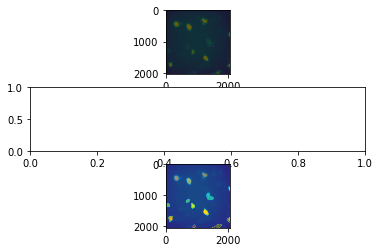

In [19]:
import contextlib
import io
from cellpose import io as iocp
from cellpose import plot,utils
    
    
    
model = cellpose_model(GPU=False)
model_nuc = cellpose_model(GPU=False,model_type='nuclei')

f = open("/home/jmamede/Data/analysis2.csv", 'wt')
output = csv.writer(f
#                     , delimiter=',',
#                             quotechar='"', quoting=csv.QUOTE_MINIMAL
                   )
output.writerow(["Well","VisitPoint","num_cells","infected_cells","percentage"])

f2 = open("/home/jmamede/Data/analysisWells.csv", 'wt')
output2 = csv.writer(f2
#                     , delimiter=',',
#                             quotechar='"', quoting=csv.QUOTE_MINIMAL
                   )
output2.writerow(["Well","VisitPoint","num_cells","infected_cells","percentage"])

for ficheiro in filelist:
    reader = ND2Reader(ficheiro)
#     metadata = reader.metadata
    reader.bundle_axes = 'cyx'
    reader.iter_axes = 'z'
    #there is a bug, it reads each visit point as a Z.
    reader.default_coords['v'] = 0
    ncells = 0
    nnuclei = 0
    
    for i in range(reader.sizes['z']):
        #shut cellpose messages up.
        with contextlib.redirect_stdout(io.StringIO()):
            
            cells_masks = cellpose_mask(reader[i][1],model
            #                             ,size=2500
                                        ,flow_threshold=0.8,size=0,diam=100,cell_prob=-1
                                       )
            nuclei_masks = cellpose_mask(reader[i][0],model_nuc
            #                             ,size=2500
                                        ,flow_threshold=1.2,size=0,diam=50,cell_prob=0
                                       )
            ncells += cells_masks.max()
            nnuclei += nuclei_masks.max()
            base = os.path.splitext(ficheiro)[0]
            outlines = utils.outlines_list(cells_masks)
            cell_outlines = utils.masks_to_outlines(cells_masks)
            iocp.outlines_to_text(base+'v'+str(i), outlines)
            f,axarr =  plots(reader,cells_masks,nuclei_masks,base)
    
        text = "Image#: {0} Number of Nuclei: {1} Number of positive cells: {2} Percentage: {3}".format(i,nuclei_masks.max(),cells_masks.max(),cells_masks.max()/nuclei_masks.max())
        print(ficheiro,text)
        output.writerow([ficheiro,i,nuclei_masks.max(),cells_masks.max(),cells_masks.max()/nuclei_masks.max()*100])
    output2.writerow(([ficheiro,'NA',nnuclei,ncells,ncells/nnuclei*100]))
f.close()

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

In [ ]:
from cellpose.utils import 

plt.imshow(masks_to_outlines(cells_masks))